# Project: Mobile robot planning, control and estimation

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import utils
import numpy as np
import pinocchio as pin
import matplotlib.pyplot as plt
from pinocchio.visualize import MeshcatVisualizer
from meshcat.transformations import translation_matrix, rotation_matrix
from meshcat.geometry import Box, MeshPhongMaterial, Cylinder
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Visualization

In [2]:
# specify a path the the urdf files and meshes
urdf_model_path = "diffdrive.urdf"
mesh_dir = ""

# load the robot using pinocchio
robot = pin.RobotWrapper.BuildFromURDF(urdf_model_path, mesh_dir)

# vizualize the robot using meshcat
viz = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(loadModel=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
# Add a floor
# Add floor material
material_floor = MeshPhongMaterial()
material_floor.color = int(200) * 256**2 + int(200) * 256 + int(200)
# Add a floor
viz.viewer["/Floor"].set_object(
    Box([10, 10, 0.01]),
    material_floor
)
viz.viewer["/Floor"].set_transform(
    translation_matrix([0, 0, -0.005])
)

# Add obstacle material
material_obstacle = MeshPhongMaterial()
material_obstacle.color = int(100) * 256**2 + int(100) * 256 + int(100)

# Randomly generate 10 obstacle positions within a defined range
np.random.seed(6) #6
obstacle_positions = [
    np.array([np.random.uniform(-4.8, 4.8), np.random.uniform(-4.8, 4.8), 0.5])
    for _ in range(10)
]

# add cylinders for each obstacle
for i, pos in enumerate(obstacle_positions):
    viz.viewer[f"/Obstacle_{i}"].set_object(
        Cylinder(1, 0.2), material_obstacle
    )
    T_world_obs = translation_matrix(pos)
    T_world_obs[:3, :3] = pin.utils.rotate('x', np.pi / 2)
    viz.viewer[f"/Obstacle_{i}"].set_transform(
        T_world_obs
    )
for i, pos in enumerate(obstacle_positions[::2]):
    # Connect a wall (box) between the two obstacles
    wall_length = np.linalg.norm(obstacle_positions[2*i][:2] - obstacle_positions[2*i+1][:2])
    wall_width = 0.4
    wall_height = 1.0
    wall_material = MeshPhongMaterial()
    wall_material.color = int(100) * 256**2 + int(100) * 256 + int(100)

    wall_position = (obstacle_positions[2*i][:2] + obstacle_positions[2*i+1][:2]) / 2

    viz.viewer[f"/Wall_Obstacle_{i}"].set_object(
        Box([wall_length, wall_width, wall_height]), wall_material
    )
    # Set the wall rotation to align with the line between the two obstacles
    angle = np.arctan2(
        obstacle_positions[2*i+1][1] - obstacle_positions[2*i][1],
        obstacle_positions[2*i+1][0] - obstacle_positions[2*i][0]
    )
    viz.viewer[f"/Wall_Obstacle_{i}"].set_transform(
        translation_matrix([wall_position[0], wall_position[1], wall_height / 2]) @
        rotation_matrix(angle, [0, 0, 1])
    )

# Add walls around the floor
wall_thickness = 0.1
wall_height = 1.0

# Left wall
viz.viewer["/Wall_Left"].set_object(Box([wall_thickness, 10, wall_height]))
viz.viewer["/Wall_Left"].set_transform(
    translation_matrix([-5 - wall_thickness / 2, 0, wall_height / 2])
)

# Right wall
viz.viewer["/Wall_Right"].set_object(Box([wall_thickness, 10, wall_height]))
viz.viewer["/Wall_Right"].set_transform(
    translation_matrix([5 + wall_thickness / 2, 0, wall_height / 2])
)

# Front wall
viz.viewer["/Wall_Front"].set_object(Box([10, wall_thickness, wall_height]))
viz.viewer["/Wall_Front"].set_transform(
    translation_matrix([0, 5 + wall_thickness / 2, wall_height / 2])
)

# Back wall
viz.viewer["/Wall_Back"].set_object(Box([10, wall_thickness, wall_height]))
viz.viewer["/Wall_Back"].set_transform(
    translation_matrix([0, -5 - wall_thickness / 2, wall_height / 2])
)

# can you add a tower in each corner of the walls?
tower_height = 1.5
tower_radius = 0.3
tower_material = MeshPhongMaterial()
tower_material.color = int(100) * 256**2 + int(100) * 256 + int(100)

tower_positions = [
    np.array([-5 - wall_thickness / 2, 5 + wall_thickness / 2, tower_height / 2]),
    np.array([5 + wall_thickness / 2, 5 + wall_thickness / 2, tower_height / 2]),
    np.array([-5 - wall_thickness / 2, -5 - wall_thickness / 2, tower_height / 2]),
    np.array([5 + wall_thickness / 2, -5 - wall_thickness / 2, tower_height / 2])
]

for i, pos in enumerate(tower_positions):
    viz.viewer[f"/Tower_{i}"].set_object(
        Cylinder(tower_height, tower_radius), tower_material
    )
    T_world_tower = translation_matrix(pos)
    T_world_tower[:3, :3] = pin.utils.rotate('x', np.pi / 2)
    viz.viewer[f"/Tower_{i}"].set_transform(
        T_world_tower
    )

In [4]:
x,y,theta = 0,0,0
utils.show_robot(x, y, theta, viz)

## Object collision

### Definition of collision models

In [5]:
import collisions as co

# Load collision model and data of the robot
model = robot.model
data = robot.data
geom_model = robot.collision_model
geom_data = pin.GeometryData(geom_model)

robot_radius = utils.compute_robot_radius(geom_model)
print(f"Robot radius: {robot_radius:.3f} meters")

Robot radius: 0.296 meters


In [6]:
# Initialize the collision objects for all obstacles
# and the collision pairs with all robot parts

params = utils.dotdict({
    "obstacle_positions": obstacle_positions,
    "obstacle_height": 1,
    "obstacle_radius": 0.2,
    "tower_height": 1.5,
    "tower_radius": 0.3,
    "wall_thickness": 0.1,
    "wall_width": 10,
    "wall_height": 1.0,
    "conn_wall_width": 0.4,
    "conn_wall_height": 1.0,
})

geom_model, geom_data = co.init_obstacles(robot, geom_model, params)

## PRM

### PRM algorithm

In [7]:
import prm

# Hyperparameters
N = 300
k = 7
xlim = [-5,5]
ylim = [-5,5]
bias_prob = 0.5
std = 0.3

# model_config = [model, data, geom_model, geom_data]  # is_collision_free
model_config = [geom_model, robot_radius, params.obstacle_radius]  # is_collision_free_approx

In [ ]:
# Takes up to 15 min (with N=1000, k=10)
samples = prm.get_samples(N, xlim, ylim, geom_model, robot_radius, bias_prob, std)
R = prm.PRM_Graph(samples)

for p1 in range(len(R.nodes)):
    neighbors = R.knn(p1, k)
    for p2 in neighbors:
        if R.exists_edge(p1, p2):
            continue
        timesteps = R.local_path(p1, p2, n_intervals=30)
        R.add_edge(p1, p2, co.is_collision_free_approx(timesteps, *model_config))

# Visualize on MeshCat
R.show_graph(viz)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [ ]:
import networkx as nx

# Visualize on a 2d plot as a network
nodes = {i:v for i, v in enumerate(R.nodes)}

G = nx.Graph()
G.add_edges_from(R.edges)

# Use actual positions for layout
nx.draw(G, pos=nodes, node_color='lightgreen', node_size=50)
plt.title("Graph with Spatial Coordinates")
plt.show()

### Path from A to B

#### Example 1

In [41]:
# Define starting and ending points

# Example 1: from center to a corner
A = np.array([0.0, 0.0])
B = np.array([4.7, 4.7])

start, goal = R.add_nodes([A, B])

for p1 in [start, goal]:
    neighbors = R.knn(p1, k)
    for p2 in neighbors:
        if R.exists_edge(p1, p2):
            continue
        timesteps = R.local_path(p1, p2, n_intervals=50)
        R.add_edge(p1, p2, co.is_collision_free_approx(timesteps, *model_config))

# Visualize on MeshCat
R.show_graph(viz)

In [42]:
# Compute shortest path
path = R.dijkstra(start, goal)
path_edges = list(zip(path, path[1:]))
print('Shortest path:', path)

Shortest path: [100, 13, 4, 83, 80, 101]


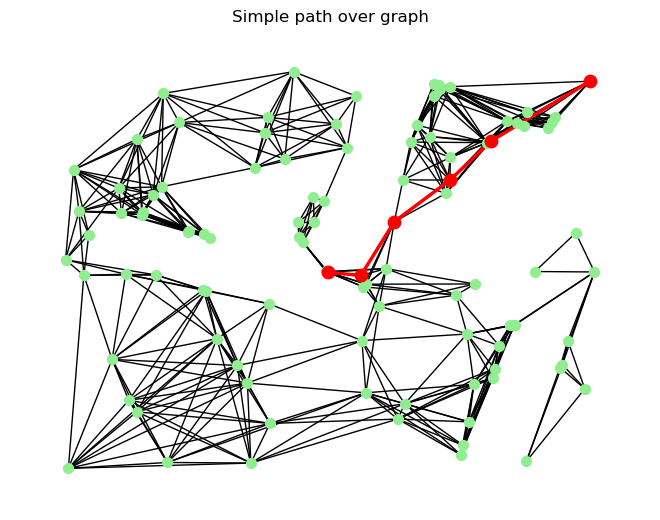

In [43]:
# Visualize on a 2d plot as a network
nodes = {i:v for i, v in enumerate(R.nodes)}
path_nodes = {i:v for i, v in zip(path, np.array(R.nodes)[path])}

G = nx.Graph()
G.add_edges_from(R.edges)

# Use actual positions for layout
nx.draw(G, pos=nodes, node_color='lightgreen', node_size=50)
nx.draw_networkx_edges(G, pos=nodes, edgelist=path_edges, edge_color='red', width=2.5)
nx.draw_networkx_nodes(G, pos=nodes, nodelist=path, node_color='red', node_size=80)
plt.title("Simple path over graph")
plt.savefig("example_1.jpg")
plt.show()

#### Example 2

In [44]:
# Define starting and ending points

# Example 2: from corner to corner
A = np.array([4.7, 4.7])
B = np.array([4.7, -4.7])

start, goal = R.add_nodes([A, B])

for p1 in [start, goal]:
    neighbors = R.knn(p1, k)
    for p2 in neighbors:
        if R.exists_edge(p1, p2):
            continue
        timesteps = R.local_path(p1, p2, n_intervals=50)
        R.add_edge(p1, p2, co.is_collision_free_approx(timesteps, *model_config))

# Visualize on MeshCat
R.show_graph(viz)

In [45]:
# Compute shortest path
path = R.dijkstra(start, goal)
path_edges = list(zip(path, path[1:]))
print('Shortest path:', path)

Shortest path: [102, 80, 83, 4, 88, 22, 75, 43, 54, 71, 0, 103]


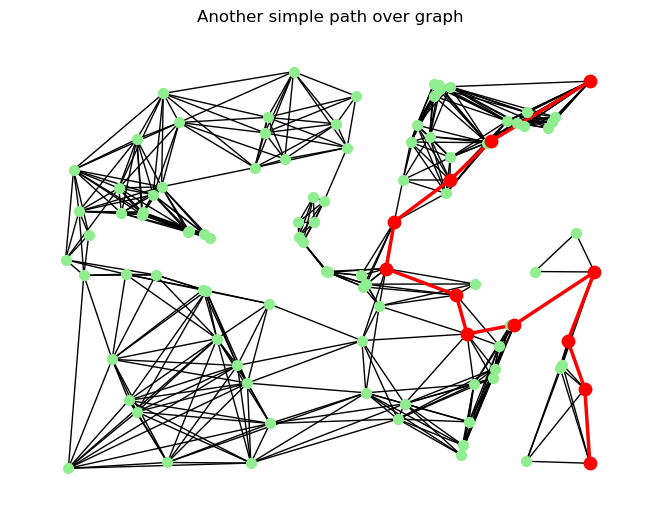

In [46]:
# Visualize on a 2d plot as a network
nodes = {i:v for i, v in enumerate(R.nodes)}
path_nodes = {i:v for i, v in zip(path, np.array(R.nodes)[path])}

G = nx.Graph()
G.add_edges_from(R.edges)

# Use actual positions for layout
nx.draw(G, pos=nodes, node_color='lightgreen', node_size=50)
nx.draw_networkx_edges(G, pos=nodes, edgelist=path_edges, edge_color='red', width=2.5)
nx.draw_networkx_nodes(G, pos=nodes, nodelist=path, node_color='red', node_size=80)
plt.title("Another simple path over graph")
plt.savefig("example_2.jpg")
plt.show()

#### Example 3

In [47]:
# Define starting and ending points

# Example 2: from corner to corner
A = np.array([0, 4.7])
B = np.array([0, -4.7])

start, goal = R.add_nodes([A, B])

for p1 in [start, goal]:
    neighbors = R.knn(p1, k)
    for p2 in neighbors:
        if R.exists_edge(p1, p2):
            continue
        timesteps = R.local_path(p1, p2)
        R.add_edge(p1, p2, co.is_collision_free_approx(timesteps, *model_config))

# Visualize on MeshCat
R.show_graph(viz)

In [48]:
# Compute shortest path
path = R.dijkstra(start, goal)
path_edges = list(zip(path, path[1:]))
print('Shortest path:', path)

Shortest path: [104, 39, 58, 72, 100, 89, 28, 63, 105]


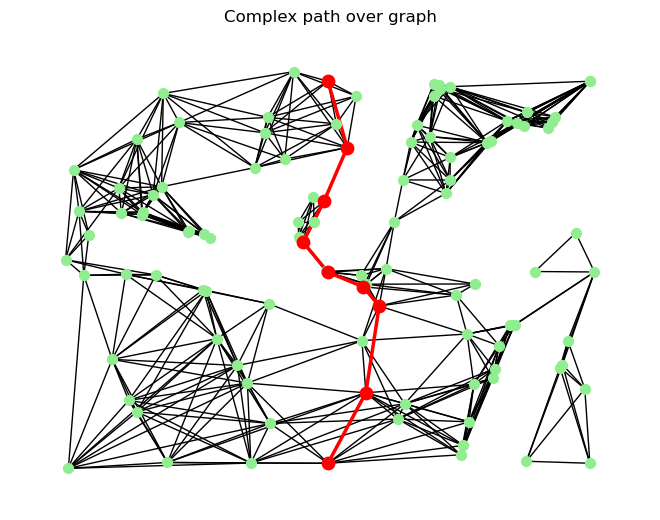

In [49]:
# Visualize on a 2d plot as a network
nodes = {i:v for i, v in enumerate(R.nodes)}
path_nodes = {i:v for i, v in zip(path, np.array(R.nodes)[path])}

G = nx.Graph()
G.add_edges_from(R.edges)

# Use actual positions for layout
nx.draw(G, pos=nodes, node_color='lightgreen', node_size=50)
nx.draw_networkx_edges(G, pos=nodes, edgelist=path_edges, edge_color='red', width=2.5)
nx.draw_networkx_nodes(G, pos=nodes, nodelist=path, node_color='red', node_size=80)
plt.title("Complex path over graph")
plt.savefig("example_3.jpg")
plt.show()

#### Example 4

In [50]:
# Define starting and ending points

# Example 2: from corner to corner
A = np.array([0, 4.7])
B = np.array([4.7, -4.7])

start, goal = R.add_nodes([A, B])

for p1 in [start, goal]:
    neighbors = R.knn(p1, k)
    for p2 in neighbors:
        if R.exists_edge(p1, p2):
            continue
        timesteps = R.local_path(p1, p2)
        R.add_edge(p1, p2, co.is_collision_free_approx(timesteps, *model_config))

# Visualize on MeshCat
R.show_graph(viz)

In [51]:
# Compute shortest path
path = R.dijkstra(start, goal)
path_edges = list(zip(path, path[1:]))
print('Shortest path:', path)

Shortest path: [106, 39, 58, 72, 100, 89, 28, 75, 43, 54, 71, 0, 107]


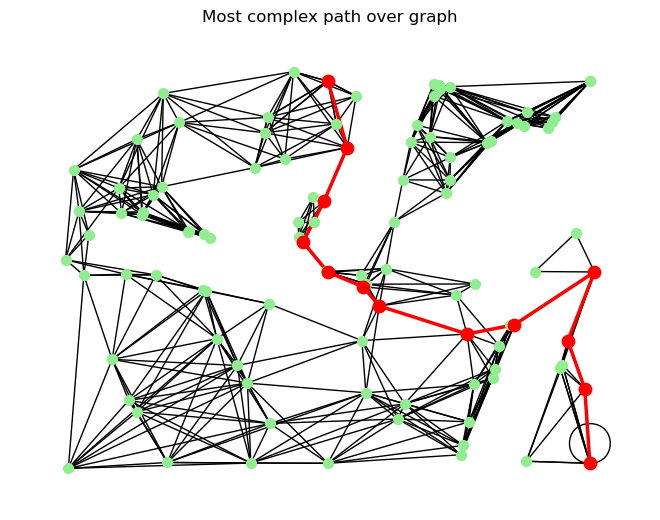

In [52]:
# Visualize on a 2d plot as a network
nodes = {i:v for i, v in enumerate(R.nodes)}
path_nodes = {i:v for i, v in zip(path, np.array(R.nodes)[path])}

G = nx.Graph()
G.add_edges_from(R.edges)

# Use actual positions for layout
nx.draw(G, pos=nodes, node_color='lightgreen', node_size=50)
nx.draw_networkx_edges(G, pos=nodes, edgelist=path_edges, edge_color='red', width=2.5)
nx.draw_networkx_nodes(G, pos=nodes, nodelist=path, node_color='red', node_size=80)
plt.title("Most complex path over graph")
plt.savefig("example_4.jpg")
plt.show()

#### Compare collision checkers time complexity

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compare pinnochio collision checker with approximate version
def benchmark(N, xlim, ylim, geom_model, geom_data, k, bias_prob, std, robot_radius, obstacle_radius, model, data):
    samples = prm.get_samples(N, xlim, ylim, geom_model, bias_prob, std)
    R = prm.PRM_Graph(samples)
    model_config = [geom_model, robot_radius, obstacle_radius]

    # Approximate checker
    start_approx = time.perf_counter()
    for p1 in range(len(R.nodes)):
        neighbors = R.knn(p1, k)
        for p2 in neighbors:
            if R.exists_edge(p1, p2): continue
            timesteps = R.local_path(p1, p2)
            R.add_edge(p1, p2, co.is_collision_free_approx(timesteps, *model_config))
    duration_approx = time.perf_counter() - start_approx

    samples = prm.get_samples(N, xlim, ylim, geom_model, bias_prob, std)
    R = prm.PRM_Graph(samples)
    model_config = [model, data, geom_model, geom_data]
    # Pinocchio checker
    start_pin = time.perf_counter()
    for p1 in range(len(R.nodes)):
        neighbors = R.knn(p1, k)
        for p2 in neighbors:
            if R.exists_edge(p1, p2): continue
            timesteps = R.local_path(p1, p2)
            R.add_edge(p1, p2, co.is_collision_free(timesteps, *model_config))
    duration_pin = time.perf_counter() - start_pin

    print(f"Approximate checker took {duration_approx:.3f} s")
    print(f"Pinocchio checker took   {duration_pin:.3f} s")
    return duration_approx, duration_pin

def scalability_test(N_values, k_values, xlim, ylim, geom_model, geom_data,
                     bias_prob, std, robot_radius, obstacle_radius, model, data):
    results = []
    for N in N_values:
        for k in k_values:
            dur_approx, dur_pin = benchmark(
                N, xlim, ylim, geom_model, geom_data,
                k, bias_prob, std,
                robot_radius, obstacle_radius,
                model, data
            )
            results.append({'N': N, 'k': k, 'method': 'approx', 'duration': dur_approx})
            results.append({'N': N, 'k': k, 'method': 'pinocchio', 'duration': dur_pin})

    df = pd.DataFrame(results)

    # Plot: duration vs N, hue=method, col per k
    g = sns.relplot(
        data=df,
        x='N', y='duration', hue='method',
        col='k', kind='line', marker='o'
    )
    g.set_axis_labels('Number of Samples N', 'Duration (s)')
    g.set_titles('k = {col_name}')
    plt.tight_layout()
    # plt.savefig('scaling_checker.jpg')
    plt.show()

In [ ]:
N_values = [50, 200, 1000]
k_values = [5, 10]
scalability_test(
    N_values, k_values,
    xlim=[-5,5], ylim=[-5,5],
    geom_model=geom_model, geom_data=geom_data,
    bias_prob=0.5, std=0.3,
    robot_radius=robot_radius, obstacle_radius=obstacle_radius,
    model=model, data=data
)

## Complete navigation pipeline

### Parameters and hyperparameters

In [22]:
# Hyperparameters
start = [-4.5, 4.5]
target = [4.5, -1.0]
theta = -np.pi

# PRM
N = 300  # number of samples
k = 10  # number of neighbors
xlim = [-5,5]
ylim = [-5,5]
bias_prob = 0.5  # bias towards obstacles
std = 0.3  # std of normal samples
model_config = [geom_model, robot_radius, params.obstacle_radius]

# Estimator
dt = 0.01
dist_per_dt = 0.05
sensor_noise_std = 0.03  # [m]
R_gps = np.diag([sensor_noise_std ** 2, sensor_noise_std ** 2])  # measurement noise
v, w = 0, 0  # initial velocities
sigma_v_pct = 0.05
sigma_w_pct = 0.05
sigma_v = v * sigma_v_pct
sigma_w = w * sigma_w_pct
P0 = np.diag([  # Initial uncertainty
    0.5**2,             
    0.5**2,             
    np.deg2rad(15.0)**2 
])


# Utils
wrap = lambda a: (a + np.pi) % (2 * np.pi) - np.pi


### Initialization of global planner and estimator

In [23]:
import prm
from localPlanner import LocalOptimalControlPlanner, DifferentialDriveModel
from estimator_ import EKF, Q_from_controls, H_gps, h_gps, F_est, f_est, f_truth

# Build PRM with random samples + start + target (takes around 2 min)
# samples = prm.get_samples(N, xlim, ylim, geom_model, robot_radius, bias_prob, std)
# samples.extend([start, target])
# R = prm.PRM_Graph(samples)

# for p1 in range(len(R.nodes)):
#     neighbors = R.knn(p1, k)
#     for p2 in neighbors:
#         if R.exists_edge(p1, p2):
#             continue
#         timesteps = R.local_path(p1, p2, n_intervals=10, t_final=0.01*10)
#         R.add_edge(p1, p2, co.is_collision_free_approx(timesteps, *model_config))

# # Compute reference path
# start_idx, target_idx = len(R.nodes) - 2, len(R.nodes) - 1
# path, distances = R.dijkstra(start_idx, target_idx, return_dist=True)
# delta_dist = [distances[i+1] - distances[i] for i in range(len(distances) - 1)]

# Compute local planning between all path nodes
pos_des, con_des = list(), list()
not_last = True
for i in range(len(path) - 1):
    n_intervals = np.ceil(delta_dist[i] / dist_per_dt)

    p1 = R.nodes[path[i]]
    p2 = R.nodes[path[i+1]]
    if i + 1 < len(path) - 1:
        p3 = R.nodes[path[i+2]]
    else:
        not_last = False

    # Theta 1 (from current to next)
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    theta = np.arctan2(dy, dx)
    p1 = np.array([*p1, theta])

    # Theta 2 (from next to next's next, if not last)
    if not_last:
        dx = p3[0] - p2[0]
        dy = p3[1] - p2[1]
    theta = np.arctan2(dy, dx)
    p2 = np.array([*p2, theta])

    # Compute local plan
    planner = LocalOptimalControlPlanner(
        model = DifferentialDriveModel(),
        t_final = n_intervals*dt,
        n_intervals = n_intervals,
        ipopt_options={"ipopt.print_level":0, "print_time":False}
    )
            
    planner.build_ocp(p1, p2)

    # straight‑line initial guess in configuration space 
    t_lin = np.linspace(0, 1, planner.n_intervals + 1) 
    x_guess = np.outer(1 - t_lin, p1) + np.outer(t_lin, p2) # (n_intervals, 3)
    planner.set_initial_guess(x_guess=x_guess.T)  # rockit expects column‑wise (3; n_intervals)

    planner.solve()
    timesteps, X, U = planner.sample()

    pos_des.extend(list(X))
    con_des.extend(list(U))

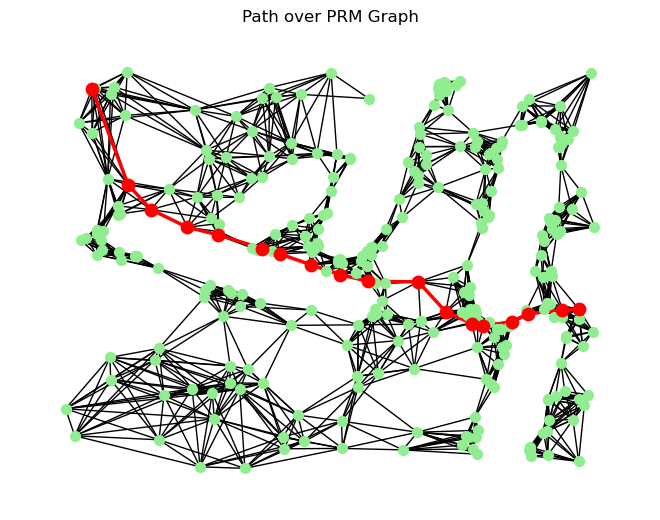

In [9]:
R.plot_path(path)

### Simulation

In [ ]:
from controller import tracking_controller
import time

# Initialize EKF estimator
pos = [*start, theta]
ekf = EKF(pos, P0, f_est, F_est, Q_from_controls(pos, dt, sigma_v, sigma_w))

# Simulate until target is reached
for i in range(len(pos_des)):
    
    # Get controls
    v, w = tracking_controller(pos, pos_des[i], con_des[i], gains=(0.2, 2.0, 7.0))
    

    # Simulate 1 timestep
    pos_t = f_truth(pos, [v, w], dt, sigma_v=sigma_v, sigma_w=sigma_w)

    # EKF prediction
    ekf.Q = Q_from_controls(ekf.x_hat, dt, sigma_v, sigma_w)
    ekf.predict([v, w], dt)
    pos = ekf.x_hat

    # Normalize theta to keep it within [-pi, pi]
    theta = np.arctan2(np.sin(pos[-1]), np.cos(pos[-1]))
    pos = [*pos[:2], theta]
    theta = np.arctan2(np.sin(pos_t[-1]), np.cos(pos_t[-1]))
    pos_t = [*pos_t[:2], theta]

    # Display the robot in the visualization
    utils.show_robot(*pos, viz)

    # Pause to simulate real-time visualization
    time.sleep(dt*10)

    # GPS update
    z = h_gps(pos_t) + np.random.normal(0.0, sensor_noise_std, 2)
    nis = ekf.update(z, h_gps, H_gps, R_gps)
    